In [1]:
# %load_ext autoreload
# %autoreload 1
import sys

setupFlag = False ## Set flag to True if these aren't installed
if setupFlag:
    !{sys.executable} -m pip install astroquery
    ## https://github.com/astropy/astroquery
    !{sys.executable} -m pip install eleanor
    ## https://github.com/afeinstein20/eleanor
    !{sys.executable} -m pip install lightkurve
    ## https://github.com/KeplerGO/lightkurve
    !{sys.executable} -m pip install sncosmo

In [2]:
from useful_functions import *
from emceeHammer import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
import emcee
import corner
np.random.seed(27)
savePNG = False ## Changes matplotlib backend to save plots as pgf (default:True)
if savePNG:
    mpl.use("agg")
    plotFile = str('png')
elif not savePNG:
    mpl.use("pgf")
    mpl.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,})
    plotFile = str('pdf')

notebookPlotFlag = True ## Changes Jupyter plotting backend (default:True)
if notebookPlotFlag:
    %matplotlib notebook
elif not notebookPlotFlag:
    %matplotlib inline


gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


In [3]:
sn2020bpi_s21_dir = './Fausnaugh/sector21/cam3_ccd2/lc/lc_2020bpi_cleaned'
sn2020bpi_s21 = lcImport(sn2020bpi_s21_dir)[::2].reset_index(drop=True)
sn2020bpi_s21_dir_a = './Fausnaugh_Updated/sector21/cam3_ccd2/lc/lc_2020bpi_cleaned'
sn2020bpi_s21_a = lcImport(sn2020bpi_s21_dir_a)
sn2020bpi_s21['mjd'] = Time(sn2020bpi_s21['BTJD']+2457000.0, format='jd').mjd
sn2020bpi_s21_a['mjd'] = Time(sn2020bpi_s21_a['BTJD']+2457000.0, format='jd').mjd

sn2020bpi_s22_dir = './Fausnaugh/sector22/cam3_ccd1/lc/lc_2020bpi_cleaned'
sn2020bpi_s22 = lcImport(sn2020bpi_s22_dir)[::2]
sn2020bpi_s22_dir_a = './Fausnaugh_Updated/sector22/cam3_ccd1/lc/lc_2020bpi_cleaned'
sn2020bpi_s22_a = lcImport(sn2020bpi_s22_dir_a)
sn2020bpi_s22['mjd'] = Time(sn2020bpi_s22['BTJD']+2457000.0, format='jd').mjd
sn2020bpi_s22_a['mjd'] = Time(sn2020bpi_s22_a['BTJD']+2457000.0, format='jd').mjd
sn2020bpi_s21s22 = pd.concat([sn2020bpi_s21,sn2020bpi_s22])
sn2020bpi_s21.head()

,BTJD,TJD,cts,e_cts,bkg,bkg_model,bkg2,e_bkg2,mjd
0,1870.44408,1870.43788,-5339.0302,1368.8706,-63381.0890,1502.1435,4466.8645,1368.8706,58869.94408
1,1870.46491,1870.45871,-6841.1413,1375.3282,-60025.0642,1502.1435,-1132.7160,1375.3282,58869.96491
2,1870.48574,1870.47954,-2219.7583,1400.7610,-54125.0260,1501.2344,3038.3737,1400.7610,58869.98574
3,1870.50658,1870.50038,-10843.6913,1370.6601,-58992.6986,1501.2344,-1349.6968,1370.6601,58870.00658
4,1870.52741,1870.52121,-9069.4821,1365.9754,-65639.4792,1501.2344,3397.6044,1365.9754,58870.02741


<IPython.core.display.Javascript object>


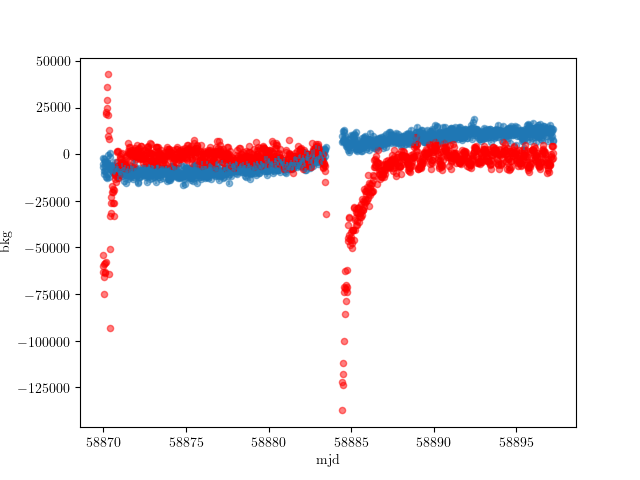

In [32]:
ax = sn2020bpi_s21_a.plot('mjd','cts',yerr='e_cts',kind='scatter',alpha=0.5)
sn2020bpi_s21_a.plot('mjd','bkg',kind='scatter',alpha=0.5,color='red',ax=ax)

In [4]:
ab = sncosmo.get_magsystem('ab')
tess_response = pd.read_csv('./tess_response_curve.csv',header=0,names=['wl_nm','trans'],engine='python' )
tess_response['wl_ang'] = (np.array(tess_response['wl_nm']) * u.nm).to_value('angstrom')

atlaso_response = pd.read_csv('./atlas_o.csv',header=0,names=['wl_ang','trans'])

sn2020bpi_ztf = pd.read_csv('./sn2020bpi_ztf.csv',header=0,engine='python' )
sn2020bpi_ztf['BTJD'] = Time(sn2020bpi_ztf['mjd'],format='mjd').jd - 2457000.0
sn2020bpi_ztf['magap_rolling'] = sn2020bpi_ztf['magap'].rolling(12).median()
sn2020bpi_ztf['flux'] = [ab.band_mag_to_flux(sn2020bpi_ztf['magap'][i], 'ztfr') for i in range(len(sn2020bpi_ztf['magap']))]
sn2020bpi_ztf['flux_rolling'] = sn2020bpi_ztf['flux'].rolling(12).median()
sn2020bpi_atlas = pd.read_csv('./sn2020bpi_atlas.csv',header=0,engine='python' )
sn2020bpi_atlas.replace(to_replace='orange-ATLAS',value='orange',inplace=True) ## covers 560-820 nm (closest to tess)
sn2020bpi_atlas.replace(to_replace='cyan-ATLAS',value='cyan',inplace=True) ## covers 420-650 nm
atlas_o = sn2020bpi_atlas[sn2020bpi_atlas.FLT == 'orange']

In [5]:
def interp_mjd(data,argData,data_index='time',arg_index='time'):
    ## More generalized version of interpToMatch(). Takes an argument for a reference
    ## DataFrame and a variable number of DataFrames to be interpolated so that
    ## they match the time sampling of the reference DataFrame. Like interpToMatch(),
    ## DataFrames must have a 'time' column of an integer or float type.
    ## Function returns an array containing the reference DataFrame as the first
    ## item followed by the interpolated DataFrames in the order in which they were
    ## passed to the function
    interpArray = []
    interpArray.append(data)
    
    data_indexed = data.set_index(str(data_index))
    data_length = len(data_indexed.index)
    minun = data_indexed.index.min()
    plusle = data_indexed.index.max()
    newIndex = data_indexed.index
    
    arg_indexed = argData.set_index(str(arg_index))
    arg_interp = pd.DataFrame(index=newIndex)
    arg_interp.index.name = arg_indexed.index.name
    for colname, col in arg_indexed.iteritems():
        arg_interp[colname] = np.interp(newIndex,arg_indexed.index,col)
    arg_interp.reset_index(inplace=True)
    return arg_interp

In [7]:
def correctionModel(params,data, modelType):
    if modelType == 'basic':
        model = params[0] * data.flux.to_numpy() + params[1]
        var = data.e_flux.to_numpy()**2
    elif modelType == 'bkg_frac':
        model = params[0] * data.flux.to_numpy() + params[1] - params[2]*data.bkg_model_flux.to_numpy()
        var = (data.e_flux.to_numpy())**2
    return model,var
def log_prior(params):
    logpr = 0.
    if params[0] < 0:
        return -np.inf
#     if params[0] > 2:
#         return -np.inf
#     if params[1] > params[0]:
#         return -np.inf
    if len(params) > 2: ##sloppy
        if params[2] < 0:
            return -np.inf
    return logpr
def log_likelihood(params,data,refData,modelType):
    model,var = correctionModel(params,data,modelType)
#     tRange = (data.mjd.min(),data.mjd.max())
#     refDataCut = refData.query('mjd > @tRange[0] & mjd < @tRange[1]')
    logl = pd.eval(-0.5 * (np.sum(np.log(2 * np.pi * var) + 
                    (refData.flux - model)**2 / var) ))
        
    return logl

def log_posterior(params,data,refData,modelType):
    logpr = log_prior(params)
    return logpr + log_likelihood(params,data,refData,modelType)
    if logpr == -np.inf:
        return logpr
    else:
        return logpr + log_likelihood(params,data,refData)

def doMCMC(data,refData, 
           guess, scale, 
           nwalkers=50, nburn=500, nsteps=1000,
           modelType='basic', plotCorner=True,
           dataType='TESS',savePlots=False,fileNameExtras='-lcAdj',plotExt='.pdf'):
    print('model: '+str(modelType))
    ndim = len(guess)
#     assert ndim == len(scale)
    starting_guesses = np.random.randn(nwalkers, ndim)*scale + guess
    
    print('sampling...')
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                    threads=-1, args=[data,refData,modelType])
    sampler.run_mcmc(starting_guesses, nsteps, progress="notebook")
    print('done')
    tlabels = [r"scale", 
               r"shift",
               "bkg mod"
           ]
    samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
    sampler.reset()
    if plotCorner:
        figcorner = corner.corner(samples, labels=tlabels[0:ndim],
                        show_titles=True, title_fmt=".6f", verbose=True,
                        title_kwargs={"fontsize": 11}, label_kwargs={"fontsize": 14})
        
    if savePlots:
        dirString = np.str('./plots/lcAdj/'+np.str(dataType)+'/corner/')
        mkdir(dirString)
        fileName = np.str('lcFit-'+'-nparam-'+np.str(len(guess)+1)+'-nwalk-'+np.str(nwalkers)+'-nstep-'+np.str(nsteps)+'-'+fileNameExtras)
        figcorner.savefig(dirString+fileName+plotExt)

    return samples

In [8]:
# guess = [0.7,0.04]
# scale = [0.1,0.01]
# doMCMC(sn2020bpi_s21s22_interpolated.query('mjd < @sn2020bpi_s21.mjd.max()').reset_index(),
#       sn2020bpi_ztf_r.query('mjd < @sn2020bpi_s21.mjd.max()').reset_index(),
#       guess, scale,
#       nwalkers=6,nburn=250,nsteps=1000);

In [15]:
def lcEmcee(dataPD,refDataPD, guess, scale, 
                 nwalkers=50, nburn=500, nsteps=1000,
                 modelType='basic',plotCorner=True,
               dataType='TESS',savePlots=False,fileNameExtras='-lcAdj',plotExt='.pdf'):
    ## Function assumes data arg is Fausnaugh provided data that is already in a
    ## DataFrame format and then applies a scale and shift factor based on the 
    ## supplied refData arg. Returns both the new dataFrame and the sampled values
    ## from MCMC. Make sure refDataPD is formatted to include an mjd column
    ## Ensure it only includes data from the relevant band (e.g. for ztf, 'fid==2')
    data = dataPD.copy()
    refData = refDataPD.copy()
    data['mjd'] = Time(data['BTJD']+2457000.0, format='jd').to_value('mjd')
    tess_interval = (((data['BTJD'].max() - data['BTJD'].min())/len(data['BTJD']))*u.d).to_value('s')
    tess_area = np.pi * 5.25**2 ## unsure about correct value, doesn't necessarily matter
    ##ask about whether this is the best option or if I should just go straight from
    ## cts to flux
    ## defining the flux as below because otherwise raw flux is orders of magnitude larger than adjusted flux
    ## https://heasarc.gsfc.nasa.gov/docs/tess/the-tess-space-telescope.html
    flux = np.array(data['cts'] / tess_interval / tess_area).astype(float)
    flux_error = np.array(data['e_cts'] / tess_interval / tess_area).astype(float)
    data['flux'] = flux
    data['e_flux'] = flux_error
    data['bkg_model_flux'] = np.array(data['bkg_model'] / tess_interval / tess_area)
    #print(data.dtypes)
    tRange = (data.mjd.min(),data.mjd.max())
    #refData = refData.query('mjd > @tRange[0] & mjd < @tRange[1]').reset_index()
    #display(data)
    data_interpolated = interp_mjd(data=refData,argData=data,
                                   data_index='mjd',arg_index='mjd')
#     refData_interpolated = interp_mjd(data=data,argData=refData,
#                                       data_index='mjd',arg_index='mjd')
## interpolating the refData is currently broken
    samples = doMCMC(data_interpolated,refData,
                     guess,scale,
                     nwalkers,nburn,nsteps,
                     plotCorner,modelType,savePlots,fileNameExtras,plotExt)
#     if savePlots:
#         dirString = np.str('./plots/lcFit/'+np.str(dataType)+'/corner/')
#         mkdir(dirString)
#         fileName = np.str('lcFit-'+'-nparam-'+np.str(len(guess)+1)+'-nwalk-'+np.str(nwalkers)+'-nstep-'+np.str(nsteps)+'-'+fileNameExtras+plotExt)
#         figcorner.savefig(dirString+fileName)

    
    return data, samples

In [16]:
def lcAdjustment(dataPD,refDataPD, guess, scale, 
                 nwalkers=50, nburn=500, nsteps=1000,
                 modelType='basic',plots=True,
               dataType='TESS',savePlots=False,fileNameExtras='',plotExt=None):
    
    mcLC,samples = lcEmcee(dataPD,refDataPD, guess, scale, 
                   nwalkers, nburn, nsteps,
                   modelType,plots, dataType,savePlots,fileNameExtras,plotExt)
    sampPD = pd.DataFrame(samples)
    sampPD.columns = ['scale','shift','bkg']
    medianParams = [np.median(samples[:,i]) for i in range(len(samples[0]))]
    cleanLC = pd.DataFrame()
    cleanLC['BTJD'] = mcLC.BTJD
    cleanLC['mjd']= mcLC.mjd
    cleanLC['cts'] = mcLC.cts
    cleanLC['e_cts'] = mcLC.e_cts
    cleanLC['bkg_model'] = mcLC.bkg_model
    cleanLC['raw_flux'] = mcLC.flux
    cleanLC['e_raw_flux'] = mcLC.e_flux
    cleanLC['bkg_model'] = mcLC.bkg_model_flux
    cleanLC['flux'], var = correctionModel(medianParams,mcLC, modelType)
    cleanLC['e_flux'] = medianParams[0]*mcLC.e_flux
    cleanLC['scale'] = medianParams[0]
    cleanLC['shift'] = medianParams[1]
    if len(medianParams) > 2:
        cleanLC['bkg_frac'] = medianParams[2]
#     dummyPD = pd.DataFrame()
#     dummyPD['flux'] = mcLC.e_flux
#     dummyPD['e_flux'] = mcLC.e_flux
#     dummyPD['bkg_model_flux'] = mcLC.bkg_model_flux
    #cleanLC['e_flux'],var = correctionModel(medianParams,dummyPD, modelType)
    #display(cleanLC)
    if plots:
        fig,ax = plt.subplots(figsize=(8,8))
        mcLC.plot('mjd','flux',kind='scatter',color='grey',alpha=0.5,label='original',ax=ax)
        cleanLC.plot('mjd','flux',kind='scatter',color='darkblue',alpha=0.2,ax=ax,label='corrected')
        refDataPD[refDataPD.mjd > cleanLC.mjd.min()][refDataPD.mjd < cleanLC.mjd.max()].plot('mjd','flux',kind='scatter',color='orange',label='ztf',ax=ax)
#         divider = make_axes_locatable(ax)
#         ax2 = divider.append_axes("bottom",size="25%",pad=0.03)
#         ax.figure.add_axes(ax2)
#         data_interpolated = interp_mjd(data=refDataPD[refDataPD.mjd > cleanLC.mjd.min()][refDataPD.mjd < cleanLC.mjd.max()],argData=mcLC,
#                                data_index='mjd',arg_index='mjd')
#         residual = data_interpolated.flux - refDataPD[refDataPD.mjd > cleanLC.mjd.min()][refDataPD.mjd < cleanLC.mjd.max()].flux 
#         ax2.scatter(data_interpolated.mjd, residual,
#         alpha=1, color='grey',s=1)
#         ax2.grid()
        plt.xlabel("mjd");
    if savePlots:
        dirString = np.str('./plots/lcAdj/'+np.str(dataType)+'/fitmodel/')
        mkdir(dirString)
        fileName = np.str('mod-'+np.str(modelType)+'-nparam-'+np.str(len(guess)+1)+'-nwalk-'+np.str(nwalkers)+'-nstep-'+np.str(nsteps)+'-'+fileNameExtras)
        fig.savefig(dirString+fileName+plotExt)

    return cleanLC, sampPD

model: bkg_frac
sampling...



done


<IPython.core.display.Javascript object>


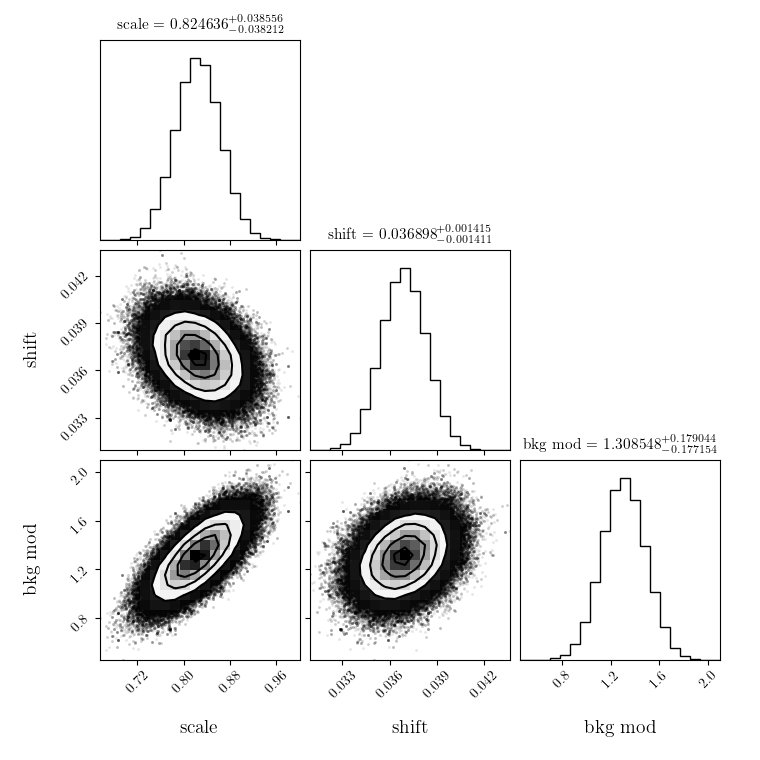

<IPython.core.display.Javascript object>


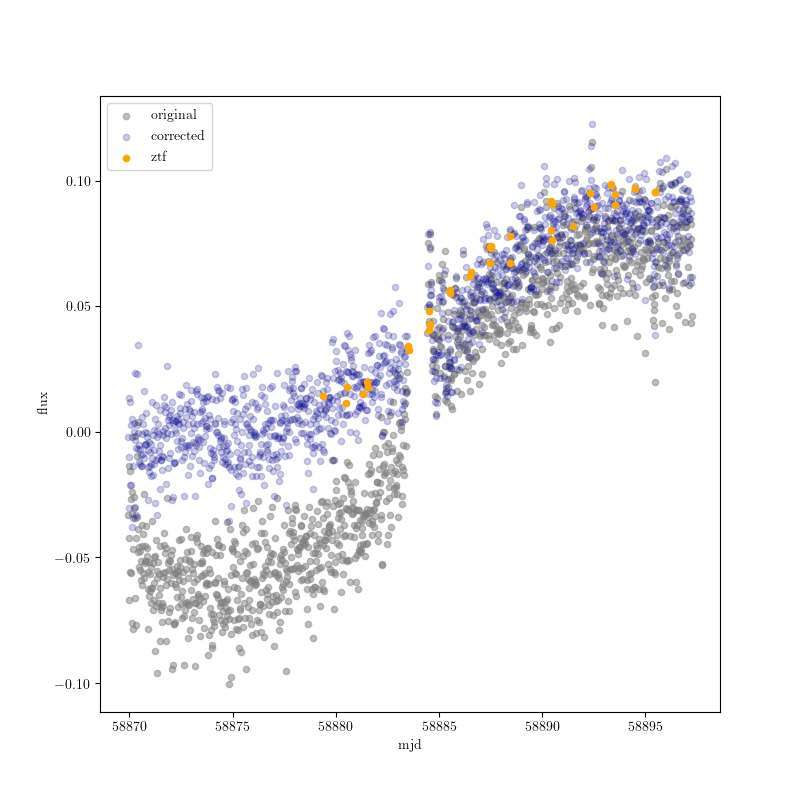

,BTJD,mjd,cts,e_cts,bkg_model,raw_flux,e_raw_flux,flux,e_flux,scale,shift,bkg_frac
0,1870.44408,58869.94408,-5339.0302,1368.8706,0.009095,-0.032976,0.008455,-0.002196,0.006972,0.824636,0.036898,1.308548
1,1870.46491,58869.96491,-6841.1413,1375.3282,0.009095,-0.042254,0.008495,-0.009847,0.007005,0.824636,0.036898,1.308548
2,1870.48574,58869.98574,-2219.7583,1400.7610,0.009095,-0.013710,0.008652,0.013691,0.007134,0.824636,0.036898,1.308548
3,1870.50658,58870.00658,-10843.6913,1370.6601,0.009095,-0.066975,0.008466,-0.030233,0.006981,0.824636,0.036898,1.308548
4,1870.52741,58870.02741,-9069.4821,1365.9754,0.009095,-0.056017,0.008437,-0.021197,0.006957,0.824636,0.036898,1.308548
...,...,...,...,...,...,...,...,...,...,...,...,...
1257,1897.67205,58897.17205,9985.5409,1085.6790,0.010174,0.061675,0.006706,0.074444,0.005530,0.824636,0.036898,1.308548
1258,1897.69288,58897.19288,12474.4539,1076.9029,0.010174,0.077047,0.006651,0.087121,0.005485,0.824636,0.036898,1.308548
1259,1897.71372,58897.21372,13437.6431,1074.2548,0.010247,0.082996,0.006635,0.091931,0.005471,0.824636,0.036898,1.308548
1260,1897.73455,58897.23455,7001.0698,1082.1323,0.010174,0.043241,0.006684,0.059243,0.005512,0.824636,0.036898,1.308548


In [14]:
guess = [0.7,0.04,0.06]
scale = [0.1,0.01,0.01]
# bpi_orig_scaled = lcAdjustment(sn2020bpi_s21,
#              sn2020bpi_ztf.query('fid == 2').reset_index(),
#              guess, scale,modelType='bkg_frac',nwalkers=50,nburn=500,nsteps=1000)
bpi_updated_scaled, samples = lcAdjustment(sn2020bpi_s21_a,
             sn2020bpi_ztf.query('fid == 2').reset_index(),
             guess, scale,modelType='bkg_frac',nwalkers=100,nburn=45000,nsteps=50000,savePlots=True,dataType='sn2020bpi',fileNameExtras='lcFit',plotExt='.pdf')
bpi_updated_scaled.to_csv('./JhaData/TESS_SN2020bpi_s21_a_MCMC.csv',index=False)
display(bpi_updated_scaled)
sampPD = pd.DataFrame(samples)
sampPD.columns = ['scale','shift','bkg']
samples.to_csv('./JhaData/TESS_SN2020bpi_s21_a_MCMC_samples.csv',index=False)

<IPython.core.display.Javascript object>


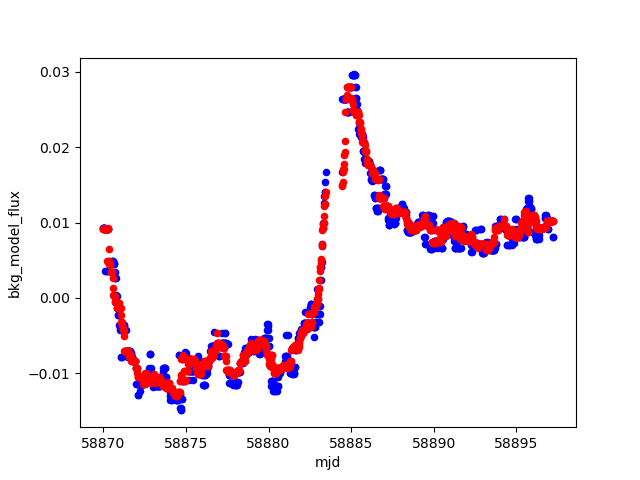

In [17]:
ax = sn2020bpi_s21.plot('mjd','bkg_model_flux',kind='scatter',color='blue')
sn2020bpi_s21_a.plot('mjd','bkg_model_flux',kind='scatter',ax=ax,color='red')

<IPython.core.display.Javascript object>


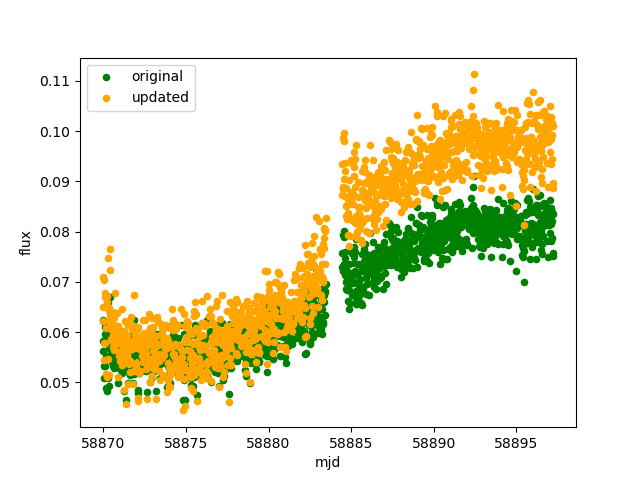

In [48]:
# ax = bpi_orig_scaled.plot('mjd','flux',color='green',kind='scatter',label='original')
# bpi_updated_scaled.plot('mjd','flux',color='orange',kind='scatter',ax=ax,label='updated')

In [21]:
params = [1,2,3]
if len(params) >3:
    if params[3] ==3:
        print('おめだとう')
else:
    print('がんばって')
    
    


がんばって
